Imports all the required libraries including PyTorch, Hugging Face `datasets` and `transformers`, scikit-learn for evaluation metrics, NumPy, Matplotlib for visualization, and `tqdm` for progress bars. These will be used throughout the sentiment classification pipeline.


In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Load the IMDb dataset using Hugging Face `datasets`. It prints the dataset structure, number of training and test samples, and shows an example entry to understand the data format.


In [ ]:
# Load the IMDb dataset

dataset = load_dataset("imdb")

# Examine the dataset structure
print(f"Dataset structure: {dataset}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"\nSample entry: {dataset['train'][0]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Training samples: 25000
Test samples: 25000

Sample entry: {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietn

Initialize the DistilBERT tokenizer and defines a preprocessing function to tokenize the IMDb text data. It applies truncation (up to 512 tokens), removes the raw text column, renames `label` to `labels` for compatibility with Hugging Face Trainer, and formats the dataset into PyTorch tensors.


In [ ]:
# Initialize the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

# Define preprocessing function
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=False,
        max_length=512
    )

# Tokenize the datasets
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text']  # Remove the original text column
)

# Rename 'label' to 'labels' for the Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set format for PyTorch
tokenized_datasets.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Load the DistilBERT model for sequence classification with 2 output labels (positive/negative). It sets up a dynamic padding collator, defines a function to compute accuracy and F1 score during evaluation, and configures training arguments including learning rate, batch sizes, number of epochs, logging, evaluation, checkpoint saving, and mixed precision training if GPU is available.


In [ ]:
# Load the model
model = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2  # Binary classification
)

# Create data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./imdb-distilbert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=500,
    save_total_limit=2,
    seed=42,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialize the Hugging Face Trainer with the model, training arguments, datasets, tokenizer, data collator, and metrics function. It then starts training the model, saves the final trained model, and saves the tokenizer for later inference.


In [ ]:
import os
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./imdb-distilbert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    logging_dir="./logs",
    logging_steps=100,
    warmup_steps=500,
    save_total_limit=2,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
train_results = trainer.train()

# Save the final model
trainer.save_model("./imdb-distilbert-final")
tokenizer.save_pretrained("./imdb-distilbert-final")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.220600,0.212464,0.918400,0.918284
2,0.154300,0.230400,0.930720,0.930714
3,0.078700,0.277136,0.932080,0.932077


('./imdb-distilbert-final/tokenizer_config.json',
 './imdb-distilbert-final/special_tokens_map.json',
 './imdb-distilbert-final/vocab.txt',
 './imdb-distilbert-final/added_tokens.json')

Evaluate the trained model on the IMDb test dataset. It computes predictions, extracts true labels, calculates accuracy and F1-score, and generates a detailed classification report (precision, recall, F1-score for positive and negative classes).


In [ ]:
# Get predictions on test set
predictions = trainer.predict(tokenized_datasets["test"])

# Extract predictions and labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Generate classification report
class_names = ['Negative', 'Positive']
report = classification_report(y_true, y_pred, target_names=class_names)

print(f"\nTest Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nDetailed Classification Report:")
print(report)


Test Set Performance:
Accuracy: 0.9321
F1-Score: 0.9321

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93     12500
    Positive       0.93      0.94      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



Extract the training history from the Hugging Face Trainer logs and visualizes key metrics. It plots training loss, validation loss, validation accuracy, and validation F1-score across epochs to help analyze model performance and detect overfitting or underfitting.


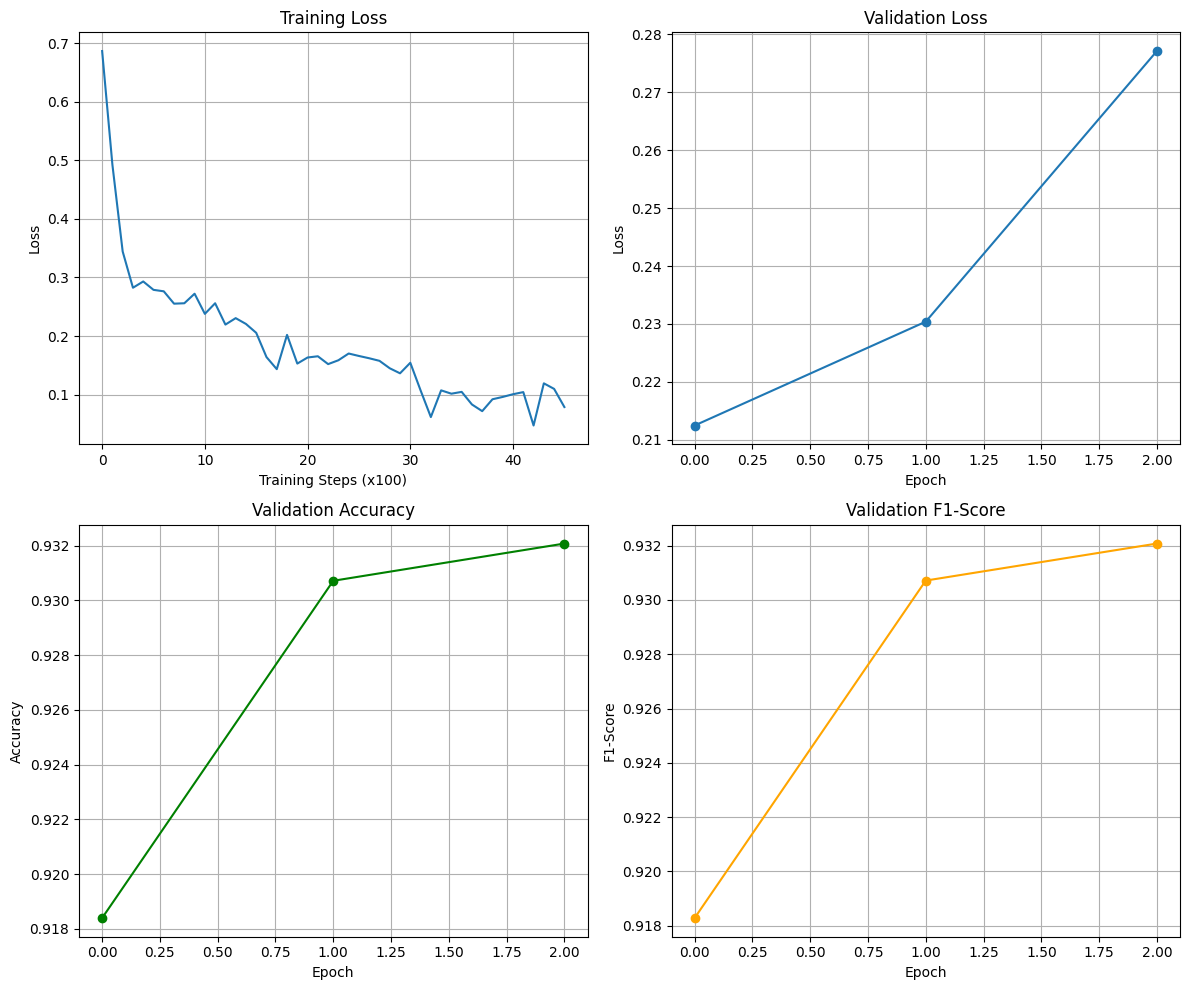

In [ ]:
# Extract training history
history = trainer.state.log_history

# Separate training and evaluation metrics
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Training Steps (x100)')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# Plot validation loss
axes[0, 1].plot(eval_loss, marker='o')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

# Plot validation accuracy
axes[1, 0].plot(eval_accuracy, marker='o', color='green')
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True)

# Plot validation F1-score
axes[1, 1].plot(eval_f1, marker='o', color='orange')
axes[1, 1].set_title('Validation F1-Score')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=100)
plt.show()

Define a helper function `predict_sentiment` that takes a text input, tokenizes it, runs it through the trained model, and returns the predicted sentiment (Positive or Negative) along with the confidence score. It also supports GPU inference if available.


In [ ]:
def predict_sentiment(text, model, tokenizer):
    """Predict sentiment for a given text."""
    # Tokenize the input
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to GPU if available
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        model = model.cuda()

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1)

    sentiment = "Positive" if prediction.item() == 1 else "Negative"
    confidence = probabilities[0][prediction].item()

    return sentiment, confidence

Test the `predict_sentiment` function with a few custom text examples. It prints the input text (truncated), the predicted sentiment, and the model’s confidence in the prediction.


In [ ]:
# Test examples
test_texts = [
    "This movie was absolutely fantastic! Best film I've seen all year.",
    "Terrible waste of time. Poor acting and boring plot.",
    "It was okay, nothing special but not bad either.",
    "The cinematography was stunning and the performances were incredible!"
]

print("\nSentiment Predictions on Custom Examples:")
print("-" * 60)
for text in test_texts:
  sentiment, confidence = predict_sentiment(text, model, tokenizer)
  print(f"Text: {text[:50]}...")
  print(f"Sentiment: {sentiment} (Confidence: {confidence:.2%})\n")


Sentiment Predictions on Custom Examples:
------------------------------------------------------------
Text: This movie was absolutely fantastic! Best film I'v...
Sentiment: Positive (Confidence: 99.69%)

Text: Terrible waste of time. Poor acting and boring plo...
Sentiment: Negative (Confidence: 99.75%)

Text: It was okay, nothing special but not bad either....
Sentiment: Negative (Confidence: 79.91%)

Text: The cinematography was stunning and the performanc...
Sentiment: Positive (Confidence: 99.69%)

